How hard is really to fit the autocorrelations (gain and T_sky) with some sort of polynomial?
Yes, I know I'm re-inventing the wheel.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyuvdata import UVData, UVCal, UVFlag, utils
from glob import glob
from astropy import units as u
from astropy import constants as c
from astropy.time import Time
from astropy.coordinates import get_body, SkyCoord, AltAz, EarthLocation, Angle
from copy import deepcopy

In [2]:
from scipy import ndimage, misc

In [3]:
# How bad is Legendre fitting with the spikes in?
from numpy.polynomial.legendre import Legendre

In [4]:
def csobel(carray):
    return ndimage.sobel(carray.real) + 1j*ndimage.sobel(carray.imag)

In [5]:
def legendreFitAuto(auto_wf, flag_wf, degree=15):
    ntimes, nfreqs = auto_wf.shape
    
    auto_fit = np.zeros_like(auto_wf)
    
    x = np.linspace(-1,1,num=nfreqs,endpoint=True)
   
    L = Legendre([1,1,1,1])
    
    for itime in np.arange(ntimes):
        spec = auto_wf[itime,:]
        specfit = L.fit(x[flag_wf[itime,:]],spec[flag_wf[itime,:]],degree,domain=[-1,1])
        x_fit, y_fit = specfit.linspace(n=nfreqs)
        auto_fit[itime, :] = y_fit
    
    return auto_fit

In [58]:
flags_or = UVFlag('/lustre/aoc/projects/hera/jaguirre/HERA19Summer2020/RawData/2457548/flag.2457548.18782.or.uvh5',
                 copy_flags=True, mode='flags')

In [61]:
flags_or.flag_array.shape
flags_or_array = flags_or.flag_array.squeeze()

In [6]:
JD = '2457548'
rawpath = '/lustre/aoc/projects/hera/jaguirre/HERA19Summer2020/RawData/'
calpath = '/lustre/aoc/projects/hera/agavidia/TimeVariability/CalFitsFix/'

In [7]:
juldate = '2457548.18782'

In [8]:
uvd = UVData()
uvd.read(rawpath+JD+'/zen.'+juldate+'.uvcRP.uvh5')

In [9]:
auto = uvd.get_data((9,9,'xx')).real
flag = uvd.get_flags((9,9,'xx'))

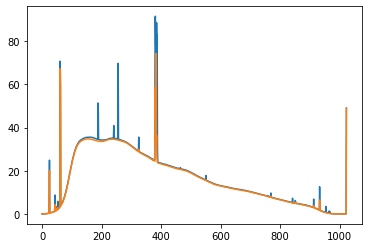

In [10]:
plt.plot(auto.max(axis=0))
plt.plot(np.median(auto, axis=0))

0.0


divide by zero encountered in true_divide
invalid value encountered in true_divide


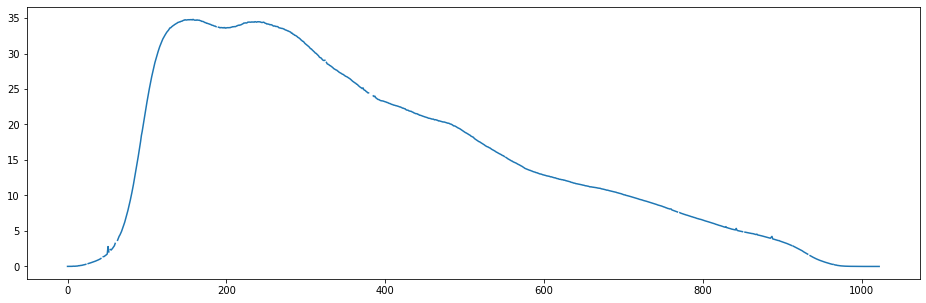

In [11]:
plt.figure(figsize=(16,5))
#plt.plot(auto[30,:])
plt.plot((auto/~flag)[30,:])
print(auto[30,:].min())

divide by zero encountered in true_divide
invalid value encountered in true_divide


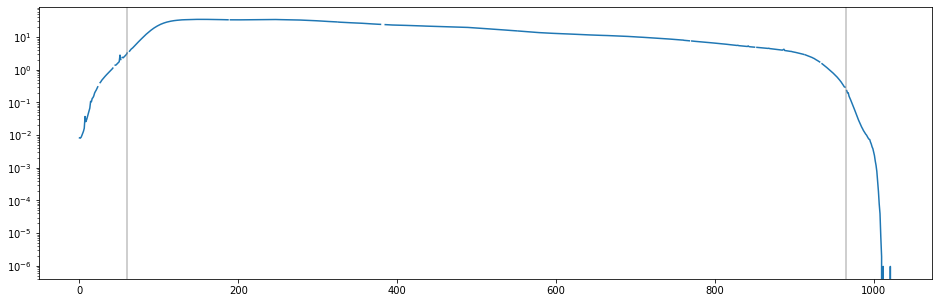

In [12]:
plt.figure(figsize=(16,5))
#plt.plot(auto[30,:])
plt.semilogy((auto/~flag)[30,:])
plt.axvline(60,color='gray',alpha=0.5)
plt.axvline(965,color='gray',alpha=0.5)

divide by zero encountered in true_divide
invalid value encountered in true_divide


(0.1, 100)

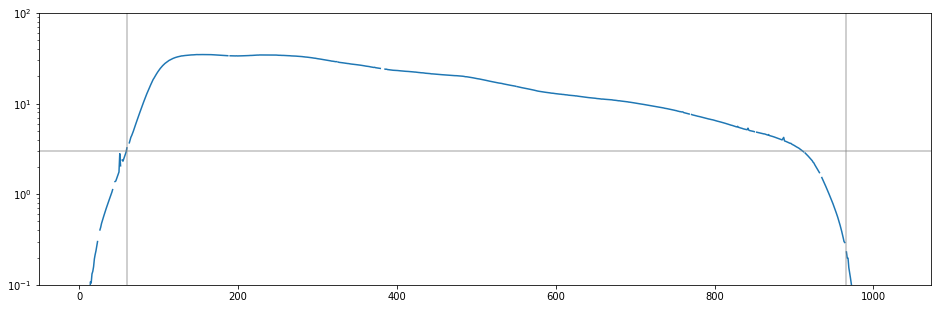

In [13]:
plt.figure(figsize=(16,5))
#plt.plot(auto[30,:])
plt.semilogy((auto/~flag)[30,:])
plt.axvline(60,color='gray',alpha=0.5)
plt.axvline(965,color='gray',alpha=0.5)
plt.axhline(3, color='gray',alpha=0.5)
plt.ylim([0.1,100])

In [14]:
auto_fit0 = legendreFitAuto(auto, ~flag, degree=50)

0.0


divide by zero encountered in true_divide
invalid value encountered in true_divide


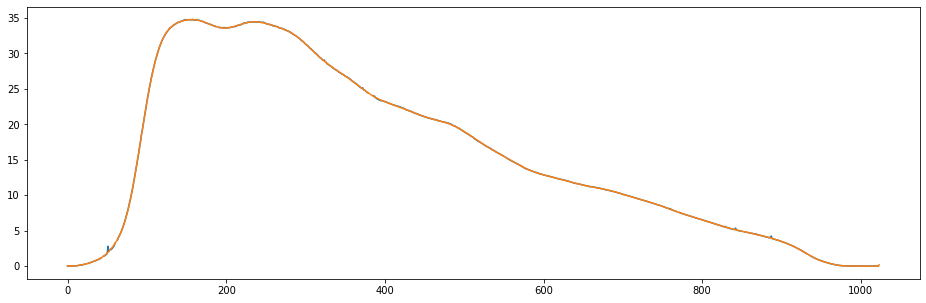

In [15]:
plt.figure(figsize=(16,5))
#plt.plot(auto[30,:])
plt.plot((auto/~flag)[30,:])
plt.plot(auto_fit0[30,:])
print(auto[30,:].min())

In [16]:
def maxhold(waterfall, flags, axis = 0):
    
    ntimes, nfreqs = waterfall.shape
    
    wfmax = np.zeros([nfreqs])
    
    for i in np.arange(nfreqs):
        if flags[:,i].sum() != 0:
            wfmax[i] = np.nanmax(waterfall[flags[:,i],i])
        else:
            wfmax[i] = np.nan
    
    return wfmax

In [17]:
test = maxhold(auto-auto_fit0, ~flag)

divide by zero encountered in true_divide


(0, 1023)

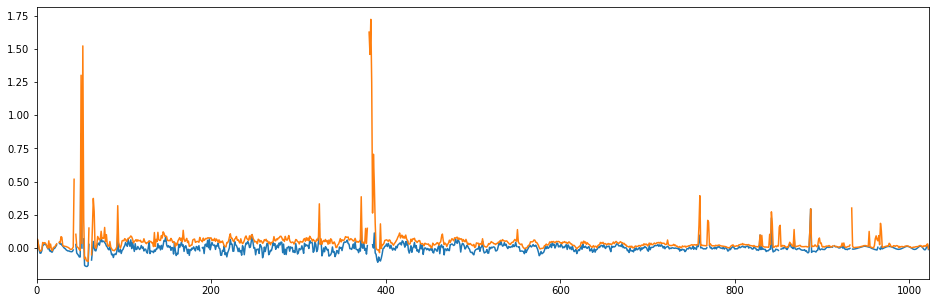

In [18]:
plt.figure(figsize=(16,5))
plt.plot(((auto-auto_fit0)/~flag)[30,:])
plt.plot(test)
#plt.plot((auto-auto_fit0).max(axis=0))
plt.xlim([0,1023])

divide by zero encountered in true_divide


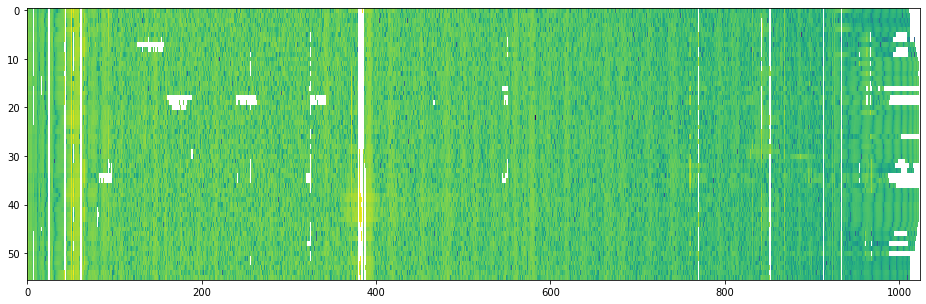

In [50]:
plt.figure(figsize=(16,5))
plt.imshow(np.log10(np.abs(auto-auto_fit0))/~flag, aspect='auto')

In [45]:
cross = uvd.get_data((9,10,'xx'))
cross_flag = uvd.get_flags((9,10,'xx'))

divide by zero encountered in log10


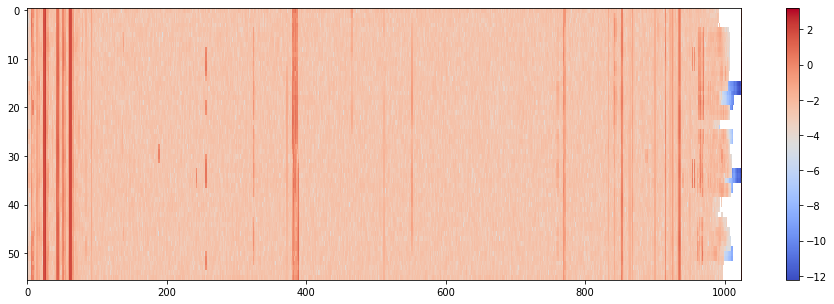

In [46]:
plt.figure(figsize=(16,5))
#plt.imshow(np.log10(np.abs(csobel(cross/auto_fit0)/~cross_flag)),aspect='auto', 
#           cmap='coolwarm')
plt.imshow(np.log10(np.abs(csobel(cross/auto_fit0))),aspect='auto', 
           cmap='coolwarm')
plt.colorbar()

divide by zero encountered in true_divide
invalid value encountered in true_divide
divide by zero encountered in log10


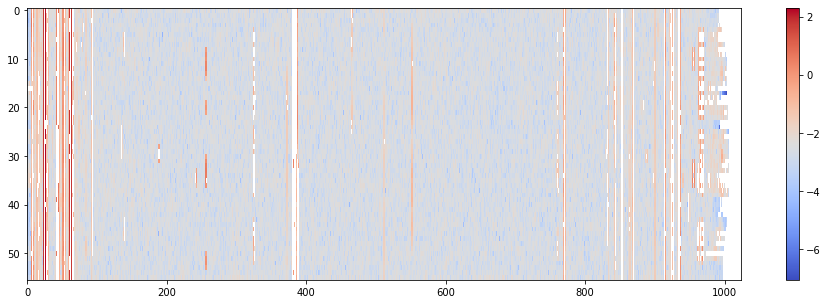

In [51]:
plt.figure(figsize=(16,5))
plt.imshow(np.log10(np.abs(csobel(cross/auto_fit0)/~cross_flag)),aspect='auto', 
           cmap='coolwarm')
#plt.imshow(np.log10(np.abs(csobel(cross/auto_fit0))),aspect='auto', 
#           cmap='coolwarm')
plt.colorbar()

divide by zero encountered in true_divide
invalid value encountered in true_divide


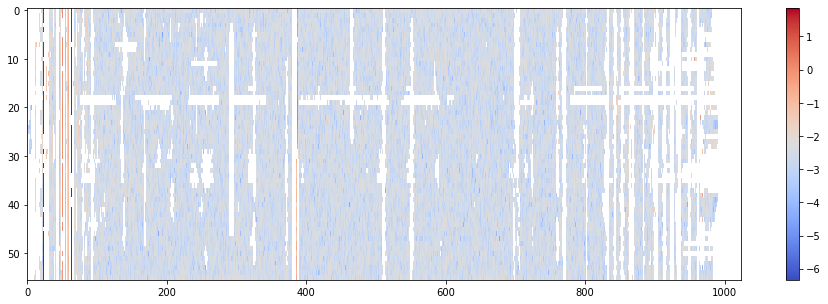

In [63]:
plt.figure(figsize=(16,5))
plt.imshow(np.log10(np.abs(csobel(cross/auto_fit0)/~flags_or_array)),aspect='auto', 
           cmap='coolwarm')
#plt.imshow(np.log10(np.abs(csobel(cross/auto_fit0))),aspect='auto', 
#           cmap='coolwarm')
plt.colorbar()

In [47]:
filtered = np.abs(csobel(cross/auto_fit0))
thresh = 8e-3

divide by zero encountered in true_divide


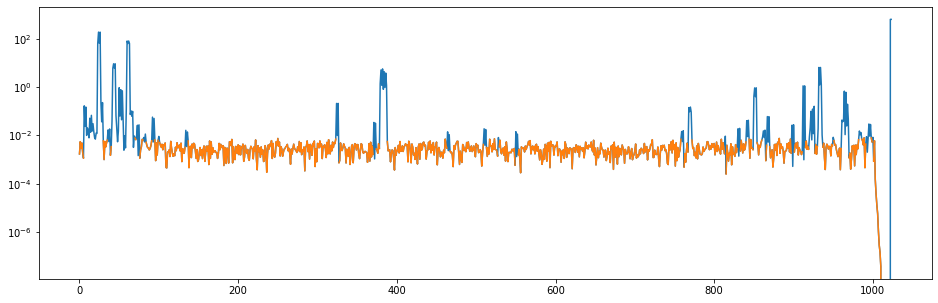

In [48]:
plt.figure(figsize=(16,5))
plt.semilogy(filtered[25,:])
plt.semilogy((filtered/(filtered < thresh))[25,:])

divide by zero encountered in true_divide


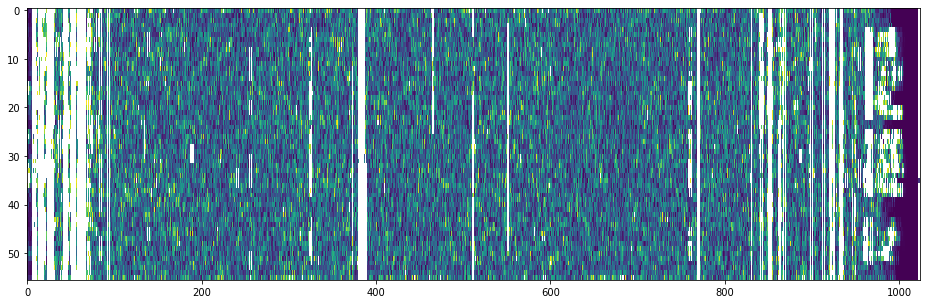

In [49]:
plt.figure(figsize=(16,5))
plt.imshow(filtered/(filtered < thresh), aspect='auto')

divide by zero encountered in log10


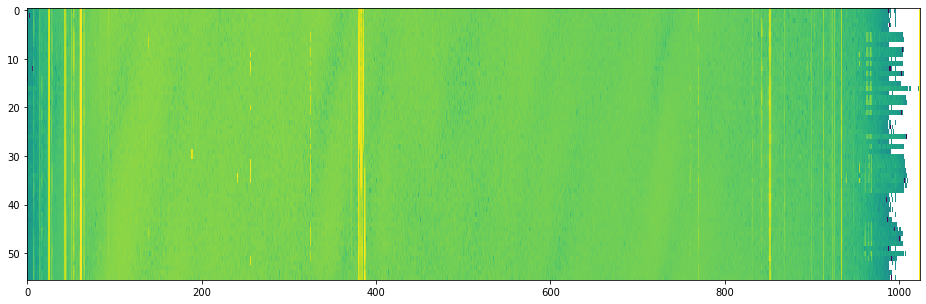

In [42]:
plt.figure(figsize=(16,5))
plt.imshow(np.log10(np.abs(cross)),aspect='auto')